In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
MY_SEED = 55

import os
import time
import json
import random
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def file_head(file, l=10):
    with open(file) as myfile:
        head_repres = [next(myfile) for x in range(l)]
    return(head_repres)

def execute(command):
    stream = os.popen(command)
    output = stream.read().strip()
    return(output)

def isNaN(num):
    return num != num

aminoacids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
diamond_groups = ['K', 'C', 'G', 'H', 'I', 'M', 'F', 'Y', 'W', 'P', 'S']

# diamond groups: [KREDQN] [C] [G] [H] [ILV] [M] [F] [Y] [W] [P] [STA]
def get_diam(aa_seq):
    diam = ""
    for aa in aa_seq:
        diam += AA_DIAM[aa]        
    return(diam)


AA_FEAT_scdiam = {'A':["sc_hydrophobic", "S"], 
           'R':["sc_poseleccharged", "K"], 
           'N':["sc_polaruncharged", "K"],
           'D':["sc_negeleccharged", "K"], 
           'C':[None,"C"], 
           'Q':["sc_polaruncharged", "K"], 
           'E':["sc_negeleccharged", "K"], 
           'G':[None,"G"],
           'H':["sc_poseleccharged", "H"], 
           'I':["sc_hydrophobic", "I"], 
           'L':["sc_hydrophobic", "I"], 
           'K':["sc_poseleccharged", "K"], 
           'M':["sc_hydrophobic", "M"],
           'F':["sc_hydrophobic", "F"], 
           'P':[None,"P"], 
           'S':["sc_polaruncharged", "S"], 
           'T':["sc_polaruncharged", "S"], 
           'W':["sc_hydrophobic", "W"],
           'Y':["sc_hydrophobic", "Y"], 
           'V':["sc_hydrophobic", "I"]
          }

AA_FEAT = {'A':["sc_hydrophobic", "A"], 
           'R':["sc_poseleccharged", "R"], 
           'N':["sc_polaruncharged", "N"],
           'D':["sc_negeleccharged", "D"], 
           'C':[None,"C"], 
           'Q':["sc_polaruncharged", "Q"], 
           'E':["sc_negeleccharged", "E"], 
           'G':[None,"G"],
           'H':["sc_poseleccharged", "H"], 
           'I':["sc_hydrophobic", "I"], 
           'L':["sc_hydrophobic", "L"], 
           'K':["sc_poseleccharged", "K"], 
           'M':["sc_hydrophobic", "M"],
           'F':["sc_hydrophobic", "F"], 
           'P':[None,"P"], 
           'S':["sc_polaruncharged", "S"], 
           'T':["sc_polaruncharged", "T"], 
           'W':["sc_hydrophobic", "W"],
           'Y':["sc_hydrophobic", "Y"], 
           'V':["sc_hydrophobic", "V"],
           '*':[None, None],
           'X':[None,None]           
          }

AA_DIAM = {'A' : "S", 'R': "K", 'N': "K", 'D': "K", 'C': "C", 'Q': "K", 'E': "K", 'G': "G", 'H': "H", 'I': "I", 'L': "I", 'K': "K", 'M': "M", 'F': "F", 'P': "P", 'S': "S", 'T': "S", 'W': "W", 'Y': "Y", 'V': "I"}


def balance_trainDS(X, y, random_state):
    wildtypeIDs = set([item[0] for item in X.index.str.split("_")])
    random.seed(random_state)
    size_smaller_group = y.value_counts().min()
    pos_IDs = set(y[y==1].index)
    neg_IDs = set(y[y==0].index)
    neg_IDs= random.sample(neg_IDs, size_smaller_group)
    pos_IDs= random.sample(pos_IDs, size_smaller_group)
    trainIDs = set(pos_IDs + neg_IDs)
    y_train = y[trainIDs]
    X_train = X.loc[trainIDs,]
    
    return(X_train, y_train)

def TFPN(ground_truth, prediction):
    TFPN = ""
    if ground_truth:
        if prediction:
            TFPN = "TP"
        else:
            TFPN = "FN"
    else:
        if prediction:
            TFPN = "FP"
        else:
            TFPN = "TN"
    return(TFPN)


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50) 

In [4]:
original_seqs = "HQprevalent_northamerica_phages_woX.faa"
hfc = pd.read_table("../avarda/hfc_pubEpitopes.csv", index_col = 0, sep = ",")
vrc_reactivity = pd.read_table("VRC_reactivity.csv", sep=",", index_col = 0)

FileNotFoundError: [Errno 2] No such file or directory: '../avarda/hfc_pubEpitopes.csv'

# Create CNN DS

In [35]:
from keras import layers
from keras.layers import Input, Dense, Activation, Flatten, Conv1D
from keras.models import Model
from keras.models import load_model
from keras.utils.vis_utils import model_to_dot
#from keras.utils import plot_model
import keras.backend as K
K.set_image_data_format('channels_last')
import tensorflow as tf 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix


In [36]:
def encodeSequences(sequences):
 
    noUniqueSeq = len(sequences)
    onehot_encoder = OneHotEncoder(sparse=False, 
                                   handle_unknown = 'ignore', 
                                   categories = [["sc_hydrophobic","sc_polaruncharged","sc_poseleccharged","sc_negeleccharged"],
                                                 #['K', 'C', 'G', 'H', 'I', 'M', 'F', 'Y', 'W', 'P', 'S']
                                                 ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
                                                ]
                                  )
    
    onehot_array = []
    print_counter = 0
    for seq in sequences:
        #print(seq)
        seq_array = []
        for aa in seq:
            seq_array.append(AA_FEAT[aa])
        seq_array = np.array(seq_array)
        #print(seq_array)
        onehot = onehot_encoder.fit_transform(seq_array)
        onehot_array.append(onehot)
        print_counter = print_counter +1
        if print_counter % 15000 == 0:
            print(str(print_counter) + " encoded")

    #print(noUniqueSeq, " sequences encoded to one hot")
    return(np.array(onehot_array))

def train_test_split_15merIndex(X, y, test_size, random_state, balanced=False):
    wildtypeIDs = set([item[0] for item in X.index.str.split("_")])
    random.seed(random_state)
    
    # first split train/test set, then balance the training set!   
    test_IDs = random.sample(wildtypeIDs, int(test_size*len(wildtypeIDs)))
    train_IDs = wildtypeIDs.difference(test_IDs)
    X_train = X.iloc[[item[0] in train_IDs for item in X.index.str.split("_")],:]
    X_test = X.iloc[[item[0] in test_IDs for item in X.index.str.split("_")],:]
    y_train = y.iloc[[item[0] in train_IDs for item in y.index.str.split("_")]]
    y_test = y.iloc[[item[0] in test_IDs for item in y.index.str.split("_")]]
    
    
    if balanced:
        size_smaller_group = y_train.value_counts().min()
        pos_IDs = set(y_train[y_train==1].index)
        neg_IDs = set(y_train[y_train==0].index)
        neg_IDs= random.sample(neg_IDs, size_smaller_group)
        pos_IDs= random.sample(pos_IDs, size_smaller_group)
        trainIDs = set(pos_IDs + neg_IDs)
        y_train = y_train[trainIDs]
        X_train = X_train.loc[trainIDs,]
    
    return(X_train, X_test, y_train, y_test)

In [37]:
cnn_ds = pd.DataFrame(columns=["seq","reactivity", "reactivity_binary"])
for index, row in hfc.iterrows():
    if "_15mer" in index :  
        seq = index.split("_")[-1][-15:]
        cnn_ds.loc[index, "reactivity"] = row.sum()
        cnn_ds.loc[index, "reactivity_binary"] = 1 if sum(row > 0) > 1 else 0        
        cnn_ds.loc[index, "seq"] = seq


In [38]:
cnn_ds

,seq,reactivity,reactivity_binary
52925_15mer_start_1_GGGGSSPPRRPPPGRRPFFH,SPPRRPPPGRRPFFH,16595.03,1
52925_15mer_start_6_GGGGSPPPGRRPFFHPVAEA,PPPGRRPFFHPVAEA,10719.11,1
52925_15mer_start_11_GGGGSRPFFHPVAEADYFEY,RPFFHPVAEADYFEY,3794.6,1
52925_15mer_start_16_GGGGSPVAEADYFEYHQEGG,PVAEADYFEYHQEGG,4508.73,1
52925_15mer_start_21_GGGGSDYFEYHQEGGPDGEP,DYFEYHQEGGPDGEP,3553.25,1
...,...,...,...
45395_15mer_start_26_GGGGSLSTRYGNVTIPFVSP,LSTRYGNVTIPFVSP,0.0,0
45395_15mer_start_31_GGGGSGNVTIPFVSPVDVPL,GNVTIPFVSPVDVPL,0.0,0
45395_15mer_start_36_GGGGSPFVSPVDVPLHTGPD,PFVSPVDVPLHTGPD,0.0,0
45395_15mer_start_41_GGGGSVDVPLHTGPDIILPS,VDVPLHTGPDIILPS,0.0,0


In [39]:
X = cnn_ds
y = (cnn_ds["reactivity_binary"]).astype(int)
X_train, X_test, y_train, y_test = train_test_split_15merIndex(X, y, 0.05, MY_SEED, balanced=True)

In [40]:
X = cnn_ds
y = (cnn_ds["reactivity_binary"]).astype(int)
#X_train_all, X_test_all, y_train, y_test = train_test_split_15merIndex(X, y, 0.05, 44, balanced=True)
X_train_all, y_train = balance_trainDS(X, y, random_state = MY_SEED)

X_train = encodeSequences(X_train_all["seq"])
#X_test = encodeSequences(X_test_all["seq"])
X_test = encodeSequences(X["seq"])
y_test = y
  
print("TRAINING BATCH:\n", y_train.value_counts())
#print("TEST BATCH:\n", y_test.value_counts())
print("TEST BATCH:\n", y.value_counts())

TRAINING BATCH:
 0    1190
1    1190
Name: reactivity_binary, dtype: int64
TEST BATCH:
 0    2266
1    1190
Name: reactivity_binary, dtype: int64


In [41]:
X_train_all

,seq,reactivity,reactivity_binary
22741_15mer_start_36_GGGGSGYDPEPAEDPVYSTV,GYDPEPAEDPVYSTV,1396.45,1
21455_15mer_start_6_GGGGSGSGAEENSNAAAAAM,GSGAEENSNAAAAAM,42.17,1
31633_15mer_start_36_GGGGSRLISCNTSVITQACP,RLISCNTSVITQACP,0.0,0
39381_15mer_start_41_GGGGSVIDSDSKSWSTVSDQ,VIDSDSKSWSTVSDQ,0.0,0
38706_15mer_start_1_GGGGSMERTEHKARKKGTSA,MERTEHKARKKGTSA,11.27,1
...,...,...,...
21029_15mer_start_21_GGGGSGETNEGLEYDEDSEN,GETNEGLEYDEDSEN,1246.79,1
12296_15mer_start_6_GGGGSPLSQPRADKPSQLKK,PLSQPRADKPSQLKK,0.0,0
57915_15mer_start_21_GGGGSLQNPPPPAIADLLQS,LQNPPPPAIADLLQS,1061.93,1
15936_15mer_start_11_GGGGSDDDSDSDSDSDSDSD,DDDSDSDSDSDSDSD,172.22,1


In [ ]:
----------------------------

In [5]:
teststop = 50
fewfortest = False
count = 0
epitile_size = 15
epitope_probaility_cutoff = 0.5
no_epis_per_tile = 3
global_tiles = {}
global_tiles_file = "dolphin_tiles_v2.fasta"
global_epitopes = {}
global_epitopes_file = "dolphin_epitopes_v2.fasta"
coverage_values = []
no_epitopes_values = []
no_tiles_values = []
prot_len_values = []
dolphin_statistics_file = "dolphin_statistics_v2.csv"

stats =  open(dolphin_statistics_file, "w")
stats.write("protID\tlength\tcoverage\tno_tiles\tno_epitopes\n")

epifile =  open(global_epitopes_file, "w")

start_time = time.time()
with open(original_seqs, "r") as org:
    for line in org.readlines():
        line = line.strip()
        if fewfortest and count/2 > teststop:
            break
        count = count + 1
        
        if (count/2)%500 == 0:
            print(str(count/2), "sequences done")

        if line.startswith(">"):
            protein = line[1:]
        else:
            no_epitopes = 0
            pseq = line
            protein_length = len(pseq)
            epitope_proba_atpos = {}

            prot_15mer_feat = kmer_features_of_protein(pseq,epitile_size)

            probas = [class_proba[1] for class_proba in clf.predict_proba(prot_15mer_feat)]
            for startpos in range(len(pseq)-epitile_size):
                epitope_proba_atpos[startpos] = probas[startpos]

            while len(epitope_proba_atpos)>0:
                max_epi_proba_pos = max(epitope_proba_atpos, key=epitope_proba_atpos.get) 
                epi_proba = epitope_proba_atpos[max_epi_proba_pos]
                epi_seq = pseq[max_epi_proba_pos:max_epi_proba_pos+epitile_size]
                if epi_proba < epitope_probaility_cutoff :
                    break
                else:
                    no_epitopes += 1
                    
                    epifile.write(">"+protein+"+"+str(max_epi_proba_pos)+"+"+str(epi_proba)+"\n")
                    epifile.write(epi_seq+"\n")

                    for pos in range(max_epi_proba_pos-epitile_size, max_epi_proba_pos+epitile_size):
                        if pos in epitope_proba_atpos:
                            del epitope_proba_atpos[pos]

            
            epi_coverage = no_epitopes * epitile_size / protein_length
            no_tiles = math.ceil(no_epitopes/no_epis_per_tile)
            
            stats.write(protein + "\t" + str(protein_length) + "\t" + str(epi_coverage) + "\t" + str(no_tiles) + "\t" + str(no_epitopes)+"\n")
            
print("classified all 15 mers")  

stats.close()
epifile.close()

end_time = time.time()

print(str(int(end_time-start_time)) + "s elapsed")

In [6]:
epifile = "dolphin_epitopes_v2.fasta"
epi_count = 0
with open(epifile, "r") as ef:
    for line in ef.readlines():
        epi_count +=1
        
epi_count/2

64045.0

In [88]:
start_time = time.time()
total_tiles = 0

epifile = "dolphin_epitopes_v2.fasta"
epi_count = 0
global_epitopes = dict()

with open(epifile, "r") as ef:
    for line in ef.readlines():
        line = line.strip()
        if line.startswith(">"):
            epi_count = epi_count + 1
            pp = line[1:].split("+")
        else:
            if line not in global_epitopes:
                global_epitopes[line] = {"probability":pp[2],"proteins":[]}            
            global_epitopes[line]["proteins"].append(pp[0])
            

epi_df = pd.DataFrame.from_dict(global_epitopes, orient='index')
epi_df["no_proteins"] = [len(v) for v in epi_df["proteins"]]
epi_df = epi_df.sort_values(by=["no_proteins", "probability"], ascending=False)
epis_to_be_treated = set(epi_df.index)
 
tilefile =  open(global_tiles_file, "w")

for epi in epi_df.index:
    if epi in epis_to_be_treated:
        #find epitopes which have the same protein set
        pset = epi_df.loc[epi,"proteins"]
        proteinset_epis=epi_df[epi_df["proteins"].apply(lambda x: x==pset)]
        epis_to_be_treated = epis_to_be_treated-set(proteinset_epis.index)
        
        #the following will drop epitopes which have lowest probability and have no partners to make tiles of 3
        no_tiles = int(len(proteinset_epis)/no_epis_per_tile)        
        protein = str(proteinset_epis.iloc[0,:]["proteins"])[1:-1]
        tiles = ["" for _ in range(no_tiles)]
        tile_probas = [list() for _ in range(no_tiles)]
        tile_seq = ""
        epi_index = 0
        for stich in range(1,no_epis_per_tile+1):
            for tn in range(no_tiles):
                tile_probas[tn].append(proteinset_epis.iloc[epi_index,:]["probability"])
                sequence = proteinset_epis.iloc[epi_index,:].name
                if stich == 1:
                    tiles[tn] = sequence
                else:
                    tiles[tn] = tiles[tn] + "_" + sequence

                epi_index = epi_index + 1

        for idx, tile in enumerate(tiles):
            tilefile.write(">"+protein+"__"+str(idx+1)+"of"+str(no_tiles)+"__prob:"+str(tile_probas[idx])+"\n")
            tilefile.write(tile+"\n")
            total_tiles += 1
            #global_tiles[protein+"_"+str(idx+1)+"of"+str(no_tiles)] = tile
        
tilefile.close()
print("total number of tiles = ", total_tiles)
end_time = time.time()
print(str(int(end_time-start_time)) + "s elapsed")

total number of tiles =  8674
111s elapsed


In [3]:
dolphin_statistics_file = "dolphin_statistics_v2.csv"
dolphin_stats = pd.read_table(dolphin_statistics_file)
dolphin_stats
print("average coverage:" , np.mean(dolphin_stats["coverage"]))  
print("average protein length:" , np.mean(dolphin_stats["length"]))  
print("average number of epitopes per protein:" , np.mean(dolphin_stats["no_epitopes"]))  
print("average number of tiles per protein:" , np.mean(dolphin_stats["no_tiles"]))  
print("total number of tiles:", sum(dolphin_stats["no_tiles"]))
print("frequency of epitopes per tile: TO BE DONE\n") #, pd.Series([len(stiched[0].split("_")) for stiched in global_tiles.values()]).value_counts())

dolphin_stats

average coverage: 0.5109351071204382
average protein length: 228.39773152187462
average number of epitopes per protein: 7.982674809921476
average number of tiles per protein: 2.9933939922722175
total number of tiles: 24016
frequency of epitopes per tile: TO BE DONE



,protID,length,coverage,no_tiles,no_epitopes
0,uvig_80910_1,336,0.580357,5,13
1,uvig_80910_2,95,0.315789,1,2
2,uvig_80910_3,570,0.421053,6,16
3,uvig_80910_4,77,0.389610,1,2
4,uvig_80910_5,83,0.722892,2,4
...,...,...,...,...,...
8018,uvig_578788_46,366,0.532787,5,13
8019,uvig_578788_47,72,0.416667,1,2
8020,uvig_578788_48,561,0.454545,6,17
8021,uvig_578788_49,125,0.480000,2,4


In [139]:
len(dolphin_stats)

NameError: name 'dolphin_stats' is not defined

In [79]:
proteinset_epis

,probability,proteins,no_proteins
EEIELEVETYERGRR,0.56,[ivig_464_41],1
LYQGESDNFNNDFLK,0.55,[ivig_464_41],1


In [58]:
epis_to_be_treated = epis_to_be_treated-set(proteinset_epis.index)

In [21]:
print("total number of (unique) epitopes: ", len(global_epitopes), "of", epi_count)
print("epitope copy frequency:\n", pd.Series([len(positions["proteins"]) for positions in global_epitopes.values()]).value_counts())


total number of (unique) epitopes:  599 of 662
epitope copy frequency:
 1    536
2     63
dtype: int64


In [8]:
for seq, positions in global_epitopes.items():
    if len(positions) == 17:
        print(seq, positions)
        #break

GRFFTYEDDEEWWKC ['>uvig_158613_5_95', '>uvig_158613_13_95', '>uvig_304445_12_95', '>uvig_307260_22_95', '>uvig_307260_30_95', '>uvig_361191_5_95', '>uvig_361191_13_95', '>uvig_430938_7_95', '>uvig_430938_15_95', '>uvig_505586_1_72', '>uvig_505586_18_95', '>uvig_509342_1_72', '>uvig_509342_19_95', '>uvig_509342_28_95', '>uvig_525990_1_72', '>uvig_535970_21_95', '>uvig_535970_29_95']
YAGTKRKFEHGLWDV ['>uvig_158613_5_53', '>uvig_158613_13_53', '>uvig_304445_12_53', '>uvig_307260_22_53', '>uvig_307260_30_53', '>uvig_361191_5_53', '>uvig_361191_13_53', '>uvig_430938_7_53', '>uvig_430938_15_53', '>uvig_505586_1_30', '>uvig_505586_18_53', '>uvig_509342_1_30', '>uvig_509342_19_53', '>uvig_509342_28_53', '>uvig_525990_1_30', '>uvig_535970_21_53', '>uvig_535970_29_53']
YVKVRENPNNKRSKV ['>uvig_158613_5_225', '>uvig_158613_13_225', '>uvig_304445_12_225', '>uvig_307260_22_225', '>uvig_307260_30_225', '>uvig_361191_5_225', '>uvig_361191_13_225', '>uvig_430938_7_225', '>uvig_430938_15_225', '>uvig_50

In [20]:
t_set = ["_".join(id_.split("_")[1:3]) for id_ in global_epitopes["GRFFTYEDDEEWWKC"]]
t_set_overlaps = {}
for seq, positions in global_epitopes.items():
    m_set = ["_".join(id_.split("_")[1:3]) for id_ in positions]
    t_set_overlaps[seq] = set(t_set).intersection(set(m_set))

In [21]:
pd.Series([len(positions) for positions in t_set_overlaps.values()]).value_counts()


0     31889
17        5
12        4
14        4
3         3
5         3
2         2
15        1
dtype: int64

[]

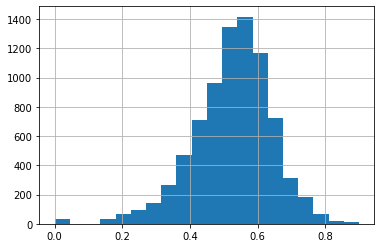

In [48]:
dolphin_stats["coverage"].hist(bins = 20).plot()

[]

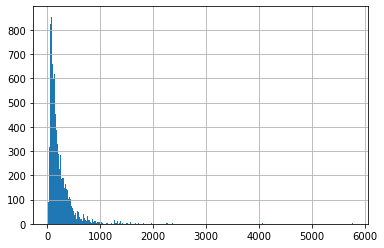

In [49]:
dolphin_stats["length"].hist(bins = 300).plot()

In [9]:
global_tiles

{'uvig_80910_1_1of4': ('WRIFGSDKDMTAEKK_VDNDDVLKADFFPFK_GRRVVTNIYGLQKDK',
  [0.78, 0.64, 0.56]),
 'uvig_80910_1_2of4': ('DKRQSIWNSGKVRFF_GWLIYSFFSTFGRSD_FELYKSYEGNNGNEK',
  [0.78, 0.63, 0.55]),
 'uvig_80910_1_3of4': ('YRMRKLKALGLNNHY_PSEPAEPPLSTEWRI_FIAEHRHFTHPETGI',
  [0.77, 0.63, 0.54]),
 'uvig_80910_1_4of4': ('HKIYKSNLVTSYRNK_AYIGIPGSGKSYEAV_VNQSLSNIARFLKDK',
  [0.65, 0.58, 0.51]),
 'uvig_80910_2_1of1': ('LFANLSDGFWYFINL_VFRSLIIKFVVFFAL', [0.65, 0.5]),
 'uvig_80910_3_1of6': ('PAIAAVAARAVIPKV_IAAAVSSFVPSSLSS_VMTNGKKISDNLYEV',
  [0.69, 0.58, 0.52]),
 'uvig_80910_3_2of6': ('NSNGDVSFTEQNYKF_INLLPFTNEFNIGSR_YLPAASSYKMSGVAT',
  [0.67, 0.58, 0.51]),
 'uvig_80910_3_3of6': ('WSEAAVNADYNGLPF_MGDRLSLCRYSWAKR_EIARNYLNDYNSRTY',
  [0.66, 0.56, 0.51]),
 'uvig_80910_3_4of6': ('VPEKEDYTTKDIDEK_FSFLWVSFPRYSYSF_HVSRNNVDAGSPVVG',
  [0.62, 0.56, 0.5]),
 'uvig_80910_3_5of6': ('TGYSTPDNALYYYQD_EYLDSVSVSPALLAD_DTGNNGNIDLGEDPG',
  [0.61, 0.55, 0.5]),
 'uvig_80910_3_6of6': ('ATRVFVGRAAANAAE_PAGIPMYENVAGLPM',

In [233]:
for seq, epi_list in global_epitopes.items():
    if len(epi_list) > 4:
        print(epi_list)

# Create Training DS and test features

In [21]:
feat = pd.DataFrame(columns = all_feature_names())
labs = pd.DataFrame(columns=["reactivity", "reactivity_binary"])
c = 0
for index, row in hfc.iterrows():
    if "_15mer" in index :  
        if c%500 == 0:
            print(str(c), "sequences done of 3456")
        c += 1
        seq = index.split("_")[-1][-15:]
        labs.loc[index, "reactivity"] = row.sum()
        labs.loc[index, "reactivity_binary"] = 1 if sum(row > 0) > 1 else 0        
        feat.loc[index] = features_of_seq(seq)


0 sequences done of 3456
500 sequences done of 3456
1000 sequences done of 3456
1500 sequences done of 3456
2000 sequences done of 3456
2500 sequences done of 3456
3000 sequences done of 3456


In [23]:
def create_DS(allfeatures, aa, d_aa, aa_double, d_aa_double, side_chain, verbose = True):
    X = allfeatures
    if (aa == False):
        X = X.drop(X.columns[[len(colname) == 1 for colname in X.columns]], axis = 1)
    else:
        if verbose:
            print("include AA features in dataset")
    if (aa_double == False):
        X = X.drop(X.columns[[len(colname) == 2 for colname in X.columns]], axis = 1)
    else:
        if verbose:
            print("include aa_double features in dataset")
    if (d_aa == False):
        X = X.drop(X.columns[[len(colname) == 3 for colname in X.columns]], axis = 1)
    else:
        if verbose:
            print("include d_aa features in dataset")
    if (d_aa_double == False):
        X = X.drop(X.columns[[len(colname) == 4 for colname in X.columns]], axis = 1)
    else:
        if verbose:
            print("include d_aa_double features in dataset")
    if (side_chain == False):
        X = X.drop(X.columns[["sc_" in colname for colname in X.columns]], axis = 1)
    else:
        if verbose:
            print("include side_chain features in dataset")
    return(X)

def train_test_split_15merIndex(X, y, test_size, random_state, balanced=False):
    wildtypeIDs = set([item[0] for item in X.index.str.split("_")])
    random.seed(random_state)
    
    # first split train/test set, then balance the training set!   
    test_IDs = random.sample(wildtypeIDs, int(test_size*len(wildtypeIDs)))
    train_IDs = wildtypeIDs.difference(test_IDs)
    X_train = X.iloc[[item[0] in train_IDs for item in X.index.str.split("_")],:]
    X_test = X.iloc[[item[0] in test_IDs for item in X.index.str.split("_")],:]
    y_train = y.iloc[[item[0] in train_IDs for item in y.index.str.split("_")]]
    y_test = y.iloc[[item[0] in test_IDs for item in y.index.str.split("_")]]
    
    
    if balanced:
        size_smaller_group = y_train.value_counts().min()
        pos_IDs = set(y_train[y_train==1].index)
        neg_IDs = set(y_train[y_train==0].index)
        neg_IDs= random.sample(neg_IDs, size_smaller_group)
        pos_IDs= random.sample(pos_IDs, size_smaller_group)
        trainIDs = set(pos_IDs + neg_IDs)
        y_train = y_train[trainIDs]
        X_train = X_train.loc[trainIDs,]
    
    return(X_train, X_test, y_train, y_test)

In [24]:
feat.to_csv("training_features.csv")
labs.to_csv("training_labels.csv")

In [33]:
X = create_DS(allfeatures = feat, aa=False, d_aa=False, aa_double=True, d_aa_double=False, side_chain=True)
y = labs["reactivity_binary"].astype('int')
y.value_counts()
X

include aa_double features in dataset
include side_chain features in dataset


,sc_hydrophobic,sc_polaruncharged,sc_poseleccharged,sc_negeleccharged,AA,AR,AN,AD,AC,AQ,AE,AG,AH,AI,AL,AK,AM,AF,AP,AS,AT,AW,AY,AV,RA,...,YS,YT,YW,YY,YV,VA,VR,VN,VD,VC,VQ,VE,VG,VH,VI,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
52925_15mer_start_1_GGGGSSPPRRPPPGRRPFFH,2,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52925_15mer_start_6_GGGGSPPPGRRPFFHPVAEA,5,0,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52925_15mer_start_11_GGGGSRPFFHPVAEADYFEY,8,0,2,3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52925_15mer_start_16_GGGGSPVAEADYFEYHQEGG,6,1,1,4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52925_15mer_start_21_GGGGSDYFEYHQEGGPDGEP,3,1,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45395_15mer_start_26_GGGGSLSTRYGNVTIPFVSP,6,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
45395_15mer_start_31_GGGGSGNVTIPFVSPVDVPL,7,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
45395_15mer_start_36_GGGGSPFVSPVDVPLHTGPD,5,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
45395_15mer_start_41_GGGGSVDVPLHTGPDIILPS,6,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [34]:
# all configurations
test_size = 0.2
#balanced = True

eval_df = pd.DataFrame()
i = 0
for aa in [True,False]:
    for d_aa in [True,False]:
        for aa_double in [True,False]:
            for d_aa_double in [True,False]:
                for side_chain in [True,False]:
                    for randomstate_tt in [60,10]:
                        for randomstate_rf in [42,123]:
                            for balanced in [True]:
                                if(aa or d_aa or aa_double or d_aa_double or side_chain):                    
                                    print("config " + str(i))
                                    X = create_DS(allfeatures = feat, aa=aa, d_aa=d_aa, aa_double=aa_double, d_aa_double=d_aa_double, side_chain=side_chain, verbose = False)
                                    X_train, X_test, y_train, y_test = train_test_split_15merIndex(X, y, test_size=test_size, random_state = randomstate_tt, balanced = balanced) 
                                    #print('Testing Features Shape:', X_test.shape)
                                    clf=RandomForestClassifier(n_estimators=100, n_jobs=6, random_state=randomstate_rf)
                                    clf.fit(X_train,y_train)
                                    y_pred=clf.predict(X_test)
                                    #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
                                    #print("Confusion Matrix:\n",metrics.confusion_matrix(y_test, y_pred))
                                    feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
                                    #print("Top 5 features\n",feature_imp[:5], "\n")

                                    #eval_df.loc[i, "balanced_train"] = balanced
                                    eval_df.loc[i, "random_state_tt"] = randomstate_tt
                                    eval_df.loc[i, "random_state_rf"] = randomstate_rf
                                    eval_df.loc[i, "no_features"] = X_test.shape[1]
                                    eval_df.loc[i, "aa"] = aa
                                    eval_df.loc[i, "d_aa"] = d_aa
                                    eval_df.loc[i, "aa_double"] = aa_double
                                    eval_df.loc[i, "d_aa_double"] = d_aa_double
                                    eval_df.loc[i, "side_chain"] = side_chain
                                    eval_df.loc[i, "Accuracy"] = metrics.accuracy_score(y_test, y_pred)
                                    eval_df.loc[i, "AUC"] = metrics.roc_auc_score(y_test, y_pred)
                                    eval_df.loc[i, "Precision"] = metrics.precision_score(y_test, y_pred)
                                    eval_df.loc[i, "Recall"] = metrics.recall_score(y_test, y_pred)
                                    eval_df.loc[i, "F1"] = metrics.f1_score(y_test, y_pred)
                                    eval_df.loc[i, "Top1"] = feature_imp.index[0]
                                    eval_df.loc[i, "Top2"] = feature_imp.index[1]
                                    eval_df.loc[i, "Top3"] = feature_imp.index[2]
                                    eval_df.loc[i, "Top4"] = feature_imp.index[3]
                                    if len(feature_imp.index) > 4:
                                        eval_df.loc[i, "Top5"] = feature_imp.index[4]
                                    #eval_df.loc[i, "CM"] = metrics.confusion_matrix(y_test, y_pred)
                                    eval_df.loc[i, "TP"] = metrics.confusion_matrix(y_test, y_pred)[1][1]
                                    eval_df.loc[i, "TN"] = metrics.confusion_matrix(y_test, y_pred)[0][0]
                                    eval_df.loc[i, "FP"] = metrics.confusion_matrix(y_test, y_pred)[0][1]
                                    eval_df.loc[i, "FN"] = metrics.confusion_matrix(y_test, y_pred)[1][0]
                                    i = i +1


config 0
config 1
config 2
config 3
config 4
config 5
config 6
config 7
config 8
config 9
config 10
config 11
config 12
config 13
config 14
config 15
config 16
config 17
config 18
config 19
config 20
config 21
config 22
config 23
config 24
config 25
config 26
config 27
config 28
config 29
config 30
config 31
config 32
config 33
config 34
config 35
config 36
config 37
config 38
config 39
config 40
config 41
config 42
config 43
config 44
config 45
config 46
config 47
config 48
config 49
config 50
config 51
config 52
config 53
config 54
config 55
config 56
config 57
config 58
config 59
config 60
config 61
config 62
config 63
config 64
config 65
config 66
config 67
config 68
config 69
config 70
config 71
config 72
config 73
config 74
config 75
config 76
config 77
config 78
config 79
config 80
config 81
config 82
config 83
config 84
config 85
config 86
config 87
config 88
config 89
config 90
config 91
config 92
config 93
config 94
config 95
config 96
config 97
config 98
config 99
config 100

In [10]:
eval_df.sort_values(by=['F1'], ascending=False)

NameError: name 'eval_df' is not defined

In [36]:
eval_eval_df = pd.DataFrame()
i = 0
for features in ["aa","d_aa","aa_double","d_aa_double","side_chain"]:
    for score in ["F1", "Recall", "Precision", "Accuracy", "AUC"]:
        eval_eval_df.loc[features, score+ "_mean"] = np.mean(eval_df[eval_df[features]==True][score])
        eval_eval_df.loc[features, score+ "_max"] = np.max(eval_df[eval_df[features]==True][score])
        eval_eval_df.loc[features, score+ "_min"] = np.min(eval_df[eval_df[features]==True][score])

In [37]:
eval_eval_df.sort_values(by=['F1_mean'], ascending=False)

,F1_mean,F1_max,F1_min,Recall_mean,Recall_max,Recall_min,Precision_mean,Precision_max,Precision_min,Accuracy_mean,Accuracy_max,Accuracy_min,AUC_mean,AUC_max,AUC_min
d_aa_double,0.461972,0.502024,0.394191,0.507304,0.553571,0.424107,0.424596,0.475610,0.368217,0.614945,0.655977,0.574344,0.587171,0.621550,0.535647
side_chain,0.460898,0.502024,0.420650,0.520915,0.569507,0.464286,0.414430,0.475610,0.349162,0.602112,0.655977,0.516788,0.581159,0.621550,0.528105
d_aa,0.460839,0.502024,0.421941,0.513442,0.569507,0.446429,0.418625,0.466926,0.374150,0.608222,0.648688,0.566423,0.583764,0.619589,0.547503
aa_double,0.460102,0.498960,0.394191,0.512690,0.569507,0.424107,0.417882,0.466926,0.368217,0.607859,0.648688,0.570803,0.583303,0.619589,0.535647
aa,0.456847,0.502024,0.394191,0.512966,0.569507,0.424107,0.412298,0.464000,0.364583,0.602299,0.647230,0.558309,0.579248,0.618777,0.535647
